# Investigate training data

The training data are a bit messy, we can't really be sure which badges were used as the numbering sheme doesn't seem to match up.

This notebook tries to answer the burning question of _which badges do we care about?_

In [76]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry.polygon import LinearRing
from scipy.misc import imread
import json
import pickle
import math

import helpers

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

Get the data out of the pickle. This is pickled by the `load candidate data from csv` notebook.

This is what we're dealing with:

In [3]:
c_data = pd.read_pickle("candidate_data.p")
c_data.head()

,minor,time,rssi,agentId
0,288,2016-11-23 23:06:34.012,-72,000000007d418b7a
1,288,2016-11-23 23:06:34.019,-82,00000000029d74c5
2,360,2016-11-23 23:06:34.059,-96,00000000c7ce4c76
3,360,2016-11-23 23:06:34.061,-75,000000005e6ed248
4,360,2016-11-23 23:06:34.061,-87,00000000fc7843f8


In [4]:
d = pickle.load( open( "infrastructure_store.p", "rb" ) )    

stickerLocations = pd.DataFrame.from_dict(d["stickerLocations"])
baseStationData  = pd.DataFrame.from_dict(d['baseStationData'])
seats            = pd.DataFrame.from_dict(d['seats'])
outer   = d['outer']
inner   = d['inner']
isovist = d['isovist']

# print ("stickerLocations")
# print (stickerLocations.head(2))
# print ("\n\nbaseStationData")
# print (baseStationData.head(2))
# print ("\n\nouter")
# print (outer[0])
# print ("\n\ninner")
# print (inner[0])
# print ("\n\nseats")
# print (seats.head(2))
# print ("\n\nisovist")
# print (isovist[0])
    
OG = nx.read_gpickle("graph.p")
# if graph.p can't be found, run BVN infrastructure and layout first

If we just have a look at what we've got here:

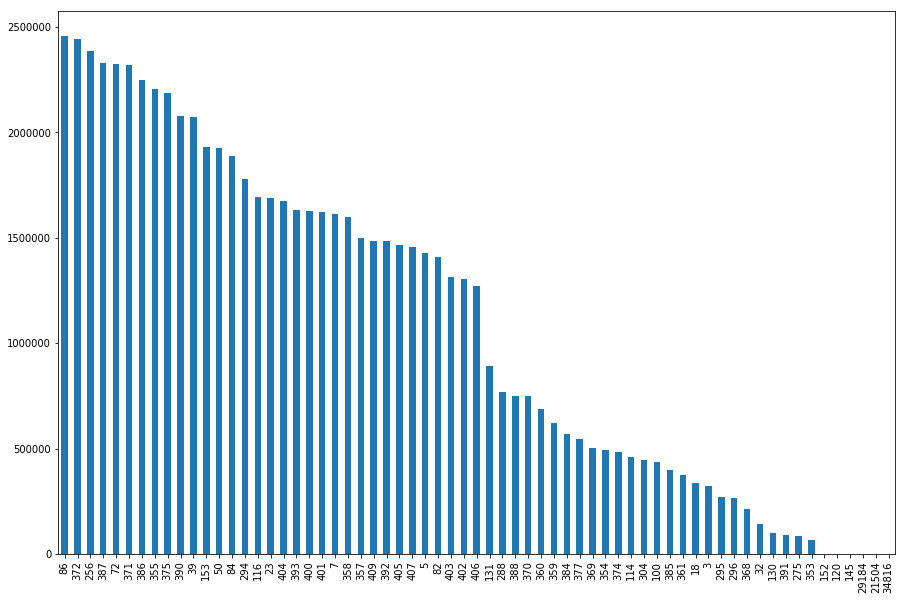

In [5]:
c_data.minor.value_counts().plot(kind="bar")

I don't really understand this, seems odd that some badges would be recorded more than others. If the badges broadcast once a seconds then I'd imagine that they should all be _more or less_ the same. I guess we'll see...

In [6]:
x = baseStationData[["agentId", "agentName"]]
c_data = c_data.merge(x, on="agentId")
del x
c_data.head()

,minor,time,rssi,agentId,agentName
0,288,2016-11-23 23:06:34.012,-72,000000007d418b7a,Monkey
1,404,2016-11-23 23:06:34.075,-74,000000007d418b7a,Monkey
2,23,2016-11-23 23:06:34.076,-84,000000007d418b7a,Monkey
3,371,2016-11-23 23:06:34.145,-73,000000007d418b7a,Monkey
4,388,2016-11-23 23:06:34.174,-84,000000007d418b7a,Monkey


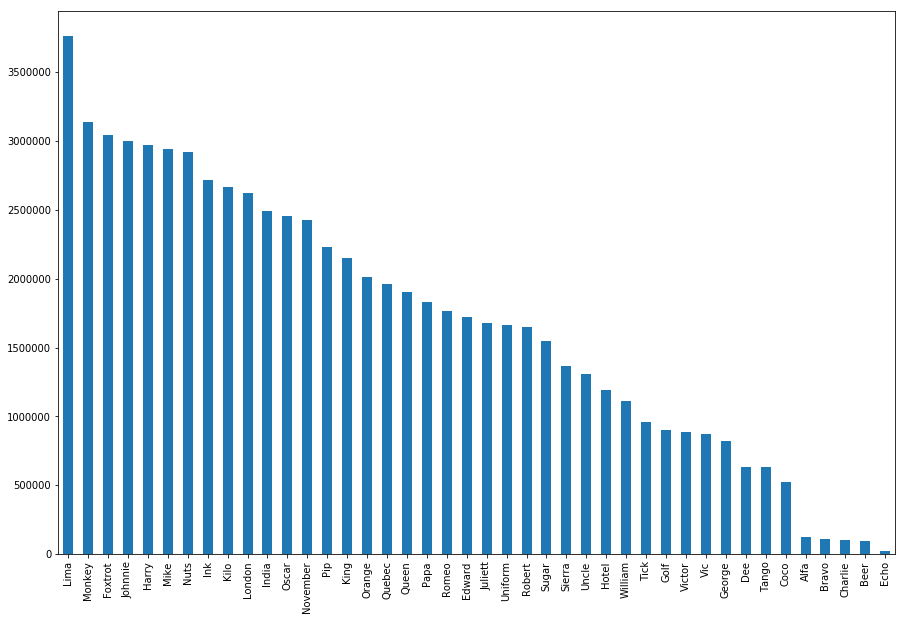

In [7]:
base_detection_counts = c_data.agentName.value_counts()
base_detection_counts.plot(kind="bar")

In [8]:
bd = base_detection_counts.to_frame().reset_index()
bd.columns =['agentName', "detection_count"]
bd = baseStationData.merge(bd, on="agentName")
bd.head()

,agentId,agentName,x,y,detection_count
0,000000006c1a3b5a,Alfa,3323.405966,9086.502512,127632
1,0000000020294bbd,Beer,3313.076869,2665.631392,95147
2,000000001159bb8a,Bravo,12030.636380,12272.735060,106587
3,000000004cb3ff60,Charlie,11735.001530,2912.053116,100910
4,00000000fe8992e8,Coco,23952.569160,6581.987542,523101


OK, at this point we can see that the north end of the office is getting much more action than the south and especially the west.

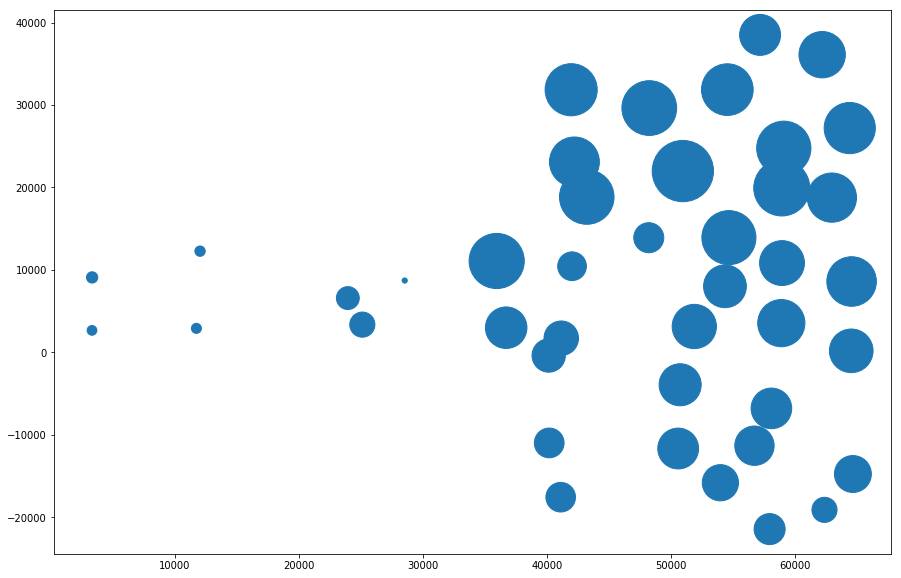

In [9]:
plt.scatter(bd.x, bd.y, s=bd.detection_count/1000, marker='o')#, c=sizes)

In an ideal world we'd see that only the badges that we care about are in the west end of the office.

In [26]:
badge_numbers = c_data.minor.unique()
print("there are {} badges detected in this period, they are:\n{}".format(len(badge_numbers), badge_numbers))

there are 65 badges detected in this period, they are:
[  288   404    23   371   388   296   304   357     5   384   369     7
   256   385   375   405   116    72   401   153   358   131    39    86
   409    84   354   387   402     3   393   355   400   390   361   360
   294    18   406    82   403   386   372   392   275   377   374   407
    50   359   370    32   295   130   368   353   391   114   145   100
 34816   120 29184   152 21504]


In [49]:
agent_names = c_data.agentName.unique()

data = pd.DataFrame(index=agent_names)

for i in range(0, len(badge_numbers)):
    s = c_data[c_data.minor==badge_numbers[i]].groupby("agentName").count().minor.to_frame()
    s.columns = [badge_numbers[i]]
    data = pd.concat([data, s], axis=1, join="outer")

data.fillna(0, inplace=True)
data.apply(pd.to_numeric)
data.head()

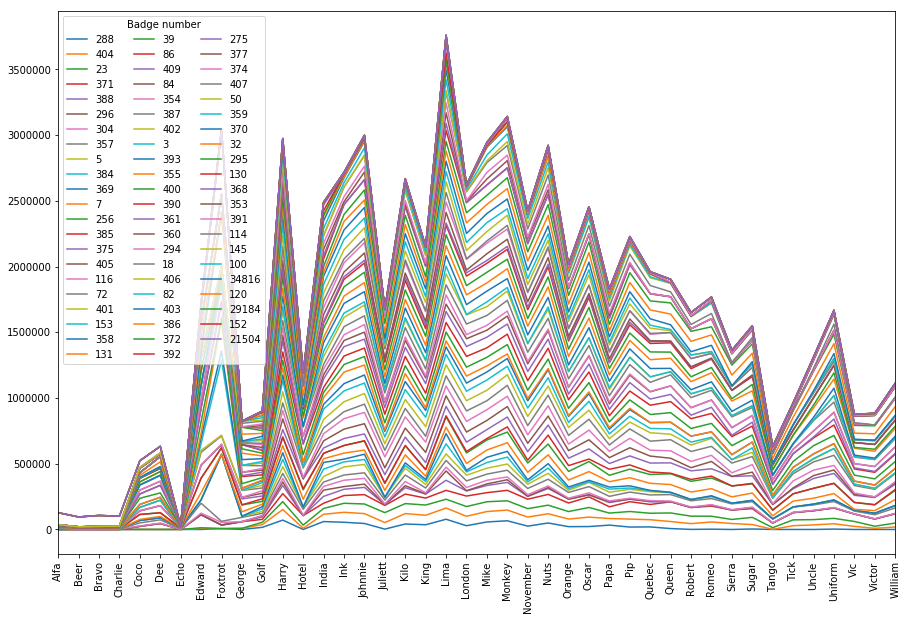

In [80]:
data.plot(stacked=True)
x = range(0, len(agent_names), 1)
plt.xticks(x)
plt.xticks(x, data.index, rotation='vertical')
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=3, shadow=False, title="Badge number", fancybox=True)

So it seems like this plot isn't actually that useful in identifying what we're looking for.

In [19]:
def draw_infrastructure(title="Sticker and Base Station Locations", draw_graph=False, draw_img=False, 
                        draw_boundaries=False, draw_axes=False, draw_stickers=False, draw_basestations=False, draw_seat_names=False,
                        pad_x_pc=0.05, pad_y_pc=0.01,
                       sticker_label_size=7, name_label_size=5, base_label_size=10):
    """Draw the fixed infrastructure of the sensicorn project."""
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    
    def plot_line(ob, colour="r"):
        x, y = ob.xy
        plt.plot(x, y, color=colour, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
    
    fig, ax = plt.subplots()

    plt.title(title)
    
    legend_items = []
    
    # set axis limits with a bit of padding
    x = [pair[0] for pair in outer[0]] # get boundary limits
    y = [pair[1] for pair in outer[0]]
    pad_y = (max(y) - min(y)) * pad_y_pc
    pad_x = (max(x) - min(x)) * pad_x_pc
    axes = plt.gca()
    axes.set_ylim([min(y) - pad_y, max(y) + pad_y])
    axes.set_xlim([min(x) - pad_x, max(x) + pad_x])
    
    if draw_img:
        # put the image on the graph as an underlay
        img = imread("map.png")
        ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
        #                                [left, right, bottom, top  ]

    if draw_boundaries:
        for boundary_set, colour in [(inner, "r"),(isovist, "g"),(outer, "b")]:
            for e in boundary_set:
                ring = LinearRing(e)
                plot_line(ring, colour)
        legend_inner = mlines.Line2D([], [], color='r', label='Inner Boundary')
        legend_isovist = mlines.Line2D([], [], color='g', label='Isovist Boundary')
        legend_outer = mlines.Line2D([], [], color='b', label='Outer Boundary')
        legend_items.extend([legend_inner, legend_isovist, legend_outer])

    if draw_graph:
        pos = {n[0]: (n[1]["x"], n[1]["y"]) for n in OG.nodes(data=True)}
        nx.draw(OG, alpha=0.3, s=1, pos=pos, node_shape=".", node_size=10)  # don't draw the graph

    if draw_basestations:
        # put the baseStations on the map
        for index, row in baseStationData.iterrows():
            if not math.isnan(row.x) and not math.isnan(row.y):
                ax.text(row.x, row.y, row.agentName, fontsize=base_label_size)
            else:
                print(row.x, row.y, row.agentName, "not shown because probably not used.")
        base_stations = ax.scatter(baseStationData.x, baseStationData.y, marker='+', label='base stations')
        legend_items.append(base_stations)

    if not draw_axes:
        # Hide the axis numbers because they don't tell us much
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if draw_stickers:
        # the sticker labels
        for _, row in stickerLocations.iterrows():
            ax.text(row.x, row.y, "{0:03d}".format(int(row.stickerID)), fontsize=sticker_label_size)

        # sticker dots
        stickers = ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y", label='stickers')
        legend_items.append(stickers)
    
    if draw_seat_names:
        for _, row in seats.iterrows():
            ax.text(row.x, row.y, row["name"], fontsize=name_label_size, rotation=10) # .name must be a reserved word?

        # sticker dots
        seat_pos = ax.scatter(seats.x, seats.y, s=1, c="y", label='seats')
        legend_items.append(seat_pos)
        
    
    if len(legend_items) > 0:
        # red_patch = mpatches.Patch(color='red', label='The red data') # patch example
        plt.legend(handles=legend_items, loc='upper left')

    plt.show()

nan nan X-ray not shown because probably not used.
nan nan X-men not shown because probably not used.
nan nan Yankee not shown because probably not used.
nan nan Yorker not shown because probably not used.
nan nan Zebra not shown because probably not used.
nan nan Zulu not shown because probably not used.


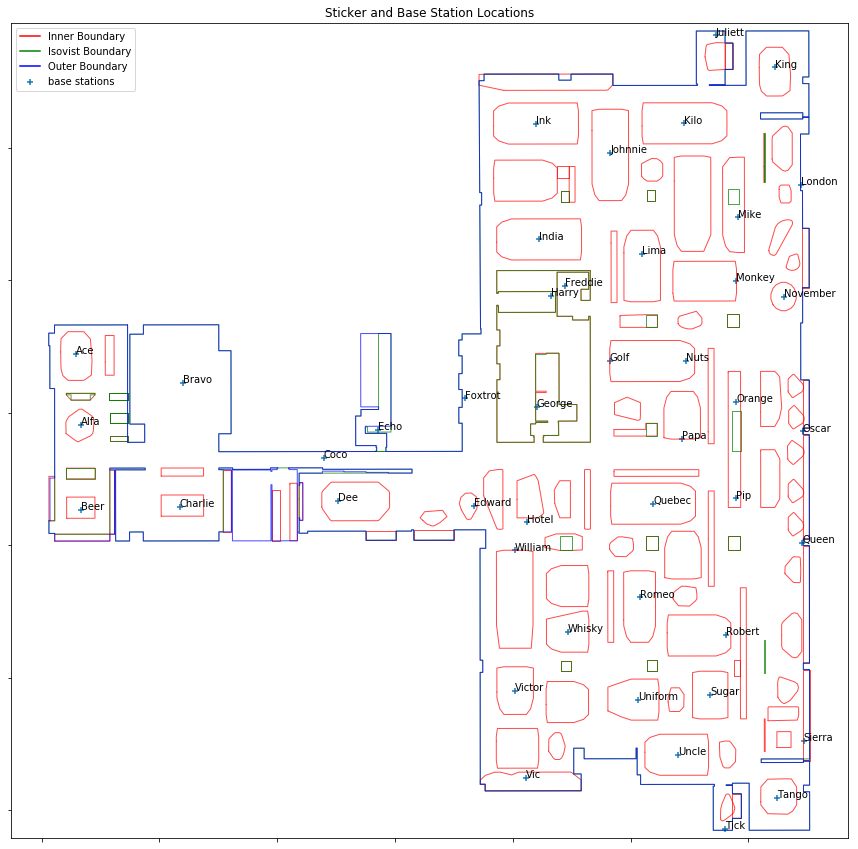

In [20]:
draw_infrastructure(draw_boundaries=True, 
                    draw_stickers=False, 
                    draw_basestations=True, 
                    draw_seat_names=False,
                    draw_graph=False)